In [1]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Load Dataframes

In [2]:
loaded_df = pd.read_parquet('turbofan_features.parquet', engine='pyarrow')
loaded_rul = pd.read_parquet('turbofan_RUL.parquet', engine='pyarrow')
loaded_df_test = pd.read_parquet('turbofan_features_test.parquet', engine='pyarrow')
loaded_rul_test = pd.read_parquet('turbofan_RUL_test.parquet', engine='pyarrow')

In [3]:
loaded_rul

,my_series
id,
"[1, 23]",3
"[1, 63]",3
"[1, 103]",2
"[1, 143]",1
"[1, 183]",0
...,...
"[709, 63]",3
"[709, 103]",3
"[709, 143]",2


In [4]:
loaded_df_test.isna().sum().sum()

0

# Split in Training and Test Data

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

X_train, y_train = loaded_df, loaded_rul['my_series']
X_validate, y_validate = loaded_df_test[loaded_df.columns], loaded_rul_test['my_series']
#y_train = y_train.astype('object')
#le = LabelEncoder()
#y_train = le.fit_transform(y_train)
print(X_train.shape, X_validate.shape)

(3983, 137) (2153, 137)


# Hyperparameter Optimization

In [6]:
from sklearn.utils import class_weight
import numpy as np
print(np.unique(y_train))
# A array object that contains the weights for both classes
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)# A dictionary object containing key-value pairs of both classes and # their weights
class_weights_dict = {0: class_weights[0], 1: class_weights[1], 2: class_weights[2], 3: class_weights[3]}
print(class_weights)
#print(f”Our class weights:\n{class_weights_dict}”)

[0 1 2 3]
[1.38106796 1.27171137 1.47956909 0.55135659]


In [7]:
from skopt.space import Categorical, Integer
from skopt import BayesSearchCV
import numpy as np
np.int = int

rf = RandomForestClassifier(class_weight=class_weights_dict)

search_space = {
        "bootstrap": Categorical([True, False]), # values for boostrap can be either True or False
        "max_depth": Integer(1, 20), # values of max_depth are integers from 1 to 20
        "max_features": Categorical(['sqrt','log2']), 
        "min_samples_leaf": Integer(3, 1000),
        "min_samples_split": Integer(3, 1000),
        "n_estimators": Integer(5, 900)
    }

rf_opt = BayesSearchCV(rf, search_space, n_iter=10, # specify how many iterations
                                    scoring="accuracy", n_jobs=-1, cv=5
                                    )
_ = rf_opt.fit(X_train, y_train) # callback=on_step will print score after each iteration

In [8]:
rf = _.best_estimator_
rf

RandomForestClassifier(class_weight={0: 1.3810679611650485,
                                     1: 1.2717113665389528,
                                     2: 1.4795690936106984,
                                     3: 0.5513565891472868},
                       max_depth=7, min_samples_leaf=147, min_samples_split=459,
                       n_estimators=300)

# Evaluation

In [9]:
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, f1_score, multilabel_confusion_matrix
from sklearn import preprocessing

def evaluation(model, X, y, set="train"):
    y_hat = model.predict(X)
    lb = preprocessing.LabelBinarizer()
    y_lb = lb.fit_transform(y)
    y_hat_lb = lb.transform(y_hat)
    #confusion = multilabel_confusion_matrix(y_lb, y_hat_lb)
    #confusion
    print(f"roc score for {set} dataset: ", roc_auc_score(y_lb, y_hat_lb, average='macro'))
    print(f'Acc Score for {set} dataset: ', accuracy_score(y_lb, y_hat_lb))
    print(f'Precision Score for {set} dataset: ', precision_score(y_lb, y_hat_lb, average='macro'))
    print(f'Recall Score for {set} dataset: ', recall_score(y_lb, y_hat_lb, average='macro'))
    print(f'f1 score for {set} dataset: ', f1_score(y_lb, y_hat_lb, average='macro'))    

In [10]:
X_train.describe()

,RUL_perc_2__minimum,RUL_perc__length,RUL_perc__mean,RUL_perc__median,RUL_max__length,s_21__length,s_20__length,s_17__length,s_3__length,s_7__length,...,RUL_max__mean,RUL_max__minimum,RUL_max__absolute_maximum,RUL_max__maximum,RUL_max__root_mean_square,RUL_max__median,s_20__absolute_maximum,s_20__maximum,s_21__maximum,s_21__absolute_maximum
count,3983.000000,3983.000000,3983.000000,3983.000000,3983.000000,3983.000000,3983.000000,3983.000000,3983.000000,3983.000000,...,3983.000000,3983.000000,3983.000000,3983.000000,3983.000000,3983.000000,3983.000000,3983.000000,3983.000000,3983.000000
mean,0.446401,73.911373,0.620603,0.620603,73.911373,73.911373,73.911373,73.911373,73.911373,73.911373,...,226.348481,226.348481,226.348481,226.348481,226.348481,226.348481,0.973696,0.973696,0.972890,0.972890
std,0.309002,25.899934,0.258699,0.258699,25.899934,25.899934,25.899934,25.899934,25.899934,25.899934,...,76.287351,76.287351,76.287351,76.287351,76.287351,76.287351,0.014620,0.014620,0.014635,0.014635
min,0.000000,23.000000,0.083026,0.083026,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,...,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,0.620922,0.620922,0.618361,0.618361
25%,0.180180,63.000000,0.382883,0.382883,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,...,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,0.970400,0.970400,0.969554,0.969554
50%,0.439560,91.000000,0.686813,0.686813,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,...,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,0.973764,0.973764,0.972804,0.972804
75%,0.720721,91.000000,0.860360,0.860360,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,...,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000,0.977127,0.977127,0.976321,0.976321
max,0.959410,91.000000,0.979705,0.979705,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,...,542.000000,542.000000,542.000000,542.000000,542.000000,542.000000,1.000000,1.000000,0.996226,0.996226


In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3983 entries, (1, 23) to (709, 223)
Columns: 137 entries, RUL_perc_2__minimum to s_21__absolute_maximum
dtypes: float64(137)
memory usage: 4.2 MB


In [12]:
evaluation(rf, X_train, y_train, set="train")
evaluation(rf, X_validate, y_validate, set="validate")

roc score for train dataset:  0.9978116141943225
Acc Score for train dataset:  0.9977403966859152
Precision Score for train dataset:  0.9987603305785124
Recall Score for train dataset:  0.9966567607726597
f1 score for train dataset:  0.997695752587592
roc score for validate dataset:  0.9626726781898738
Acc Score for validate dataset:  0.9396191360891779
Precision Score for validate dataset:  0.955110497237569
Recall Score for validate dataset:  0.9461920529801324
f1 score for validate dataset:  0.945193003398076


In [19]:
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

y_hat = rf.predict(X_validate)
lb = preprocessing.LabelBinarizer()
y_lb = lb.fit_transform(y_validate)
y_hat_lb = lb.transform(y_hat)
confusion = confusion_matrix(y_lb, y_hat_lb)
confusion

ValueError: multilabel-indicator is not supported

In [20]:
rf.predict_proba(X_validate)

array([[4.58272688e-01, 1.18474939e-01, 6.10727001e-02, 3.62179673e-01],
       [8.22270462e-03, 1.21675152e-02, 4.50812419e-02, 9.34528538e-01],
       [1.06801520e-01, 1.70159040e-01, 5.99757733e-01, 1.23281707e-01],
       ...,
       [6.57335505e-02, 1.58606554e-01, 7.47082807e-01, 2.85770880e-02],
       [1.42937117e-01, 7.93013134e-01, 6.05145484e-02, 3.53520033e-03],
       [9.07953567e-01, 8.18814604e-02, 9.64789515e-03, 5.17077470e-04]])

In [21]:
import joblib

joblib.dump(rf, "classification_model.joblib")

['classification_model.joblib']

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [24]:
cm = confusion_matrix(y_validate, y_hat)

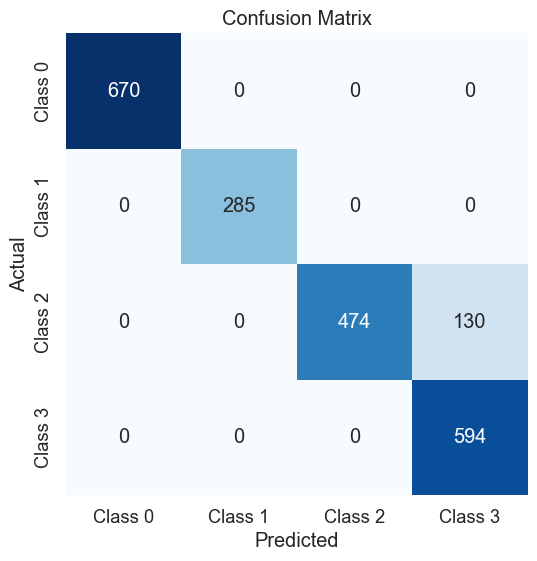

In [26]:
# Define class labels (change to your own class labels)
class_labels = ["Class 0", "Class 1", "Class 2", "Class 3"]

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font scale for better readability
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False, square=True,
            xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
